In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import librosa.display
import numpy as np
import datetime
import time
import os
import json
from skimage.transform import resize

from src.data import NSynth
from src.utils import print_and_log
from src.models import VAE

/opt/conda/lib/python3.6/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [3]:
if torch.cuda.is_available():  
    device = torch.device("cuda:0")
else:  
    device = torch.device("cpu") 

In [4]:
hparams = {
    'checkpoint' : None,
    'instrument_source' : [0, 1, 2],
    'sample_rate' : 16000,
    'n_samples' : 64000,
    'feature_type' : 'mel',
    'random_crop' : True,
    'resize' : None,
    'normalize' : True,
    'standardize' : True,
    'standardize_mean' : 0.3356,
    'standardize_std' : 0.2212,
    'spec_augment' : False,
    'remove_synth_lead' : True,
    'n_samples_per_class' : None,
    'depths' : (64, 64, 128, 128, 256, 256, 512), 
    'kl_loss_weight' : 0.001,
    'n_epochs' : 50,
    'batch_size' : 32,
    'lr' : 0.0001,
    'hidden_dim' : 512,
    'display_iters' : 100,
    'val_iters' : 1000,
    'n_val_samples' : 1000, 
    'n_early_stopping' : 5 # stop if validation doesn't improve after this number of validation cycles
}

In [5]:
train_dataset = NSynth(
    'data/nsynth', 
    'train',
    include_meta=False, 
    instrument_source=hparams['instrument_source'], 
    sample_rate=hparams['sample_rate'], 
    n_samples=hparams['n_samples'], 
    feature_type=hparams['feature_type'], 
    random_crop=hparams['random_crop'], 
    resize=hparams['resize'], 
    normalize=hparams['normalize'], 
    standardize=hparams['standardize'], 
    standardize_mean=hparams['standardize_mean'], 
    standardize_std=hparams['standardize_std'], 
    spec_augment=hparams['spec_augment'],
    remove_synth_lead=hparams['remove_synth_lead'], 
    n_samples_per_class=hparams['n_samples_per_class']
)

val_dataset = NSynth(
    'data/nsynth', 
    'val',
    include_meta=False, 
    instrument_source=hparams['instrument_source'], 
    sample_rate=hparams['sample_rate'], 
    n_samples=hparams['n_samples'], 
    feature_type=hparams['feature_type'], 
    random_crop=hparams['random_crop'], 
    resize=hparams['resize'], 
    normalize=hparams['normalize'], 
    standardize=hparams['standardize'], 
    standardize_mean=hparams['standardize_mean'], 
    standardize_std=hparams['standardize_std'], 
    remove_synth_lead=hparams['remove_synth_lead']
)

In [6]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=hparams['batch_size'], shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=hparams['batch_size'], shuffle=True)

In [7]:
model = VAE(
    h_dim=hparams['hidden_dim'], 
    sigmoid=(not hparams['standardize']),
    depths=hparams['depths']
).to(device)
print('# of parameters : {}'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)))

# of parameters : 8377921


In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr=hparams['lr'])

In [9]:
timestamp = datetime.datetime.fromtimestamp(time.time()).strftime('%Y%m%d-%H%M%S')
results_dir = 'train_results/vae/{}'.format(timestamp)
os.makedirs(results_dir)

with open(os.path.join(results_dir, 'hparams.json'), 'w') as fp:
    json.dump(hparams, fp)

log_file = os.path.join(results_dir, 'train_log.txt')
log = open(log_file, 'w')
log.close()
print_and_log('{} {}'.format(train_dataset.__class__.__name__, model.__class__.__name__), log_file)

for k, v in hparams.items(): print_and_log('{} : {}'.format(k, v), log_file)

NSynth VAE
checkpoint : None
instrument_source : [0, 1, 2]
sample_rate : 16000
n_samples : 64000
feature_type : mel
random_crop : True
resize : None
normalize : True
standardize : True
standardize_mean : 0.3356
standardize_std : 0.2212
spec_augment : False
remove_synth_lead : True
n_samples_per_class : None
depths : (32, 64, 128, 128, 256, 256, 512)
kl_loss_weight : 0.001
n_epochs : 50
batch_size : 32
lr : 0.0001
hidden_dim : 512
display_iters : 100
val_iters : 1000
n_val_samples : 1000
n_early_stopping : 5


[0,     1] loss : (total : 4.2362, recon : 4.1035, kl : 132.6703)
[0,   100] loss : (total : 0.6225, recon : 0.5486, kl : 73.8580)
[0,   200] loss : (total : 0.3617, recon : 0.3118, kl : 49.9342)
[0,   300] loss : (total : 0.3563, recon : 0.3141, kl : 42.2204)
[0,   400] loss : (total : 0.3581, recon : 0.3167, kl : 41.4386)
[0,   500] loss : (total : 0.2598, recon : 0.2238, kl : 36.0105)
[0,   600] loss : (total : 0.3740, recon : 0.3362, kl : 37.8315)
[0,   700] loss : (total : 0.2977, recon : 0.2596, kl : 38.0846)
[0,   800] loss : (total : 0.2732, recon : 0.2368, kl : 36.4121)
[0,   900] loss : (total : 0.3826, recon : 0.3429, kl : 39.7347)
[0,  1000] loss : (total : 0.2585, recon : 0.2251, kl : 33.4086)
[0,  1100] loss : (total : 0.2625, recon : 0.2246, kl : 37.9047)
[0,  1200] loss : (total : 0.3009, recon : 0.2633, kl : 37.5845)
[0,  1300] loss : (total : 0.2607, recon : 0.2249, kl : 35.8639)
[0,  1400] loss : (total : 0.2426, recon : 0.2083, kl : 34.3702)
[0,  1500] loss : (total

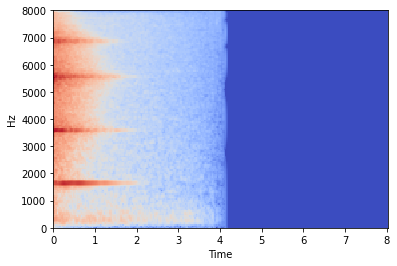

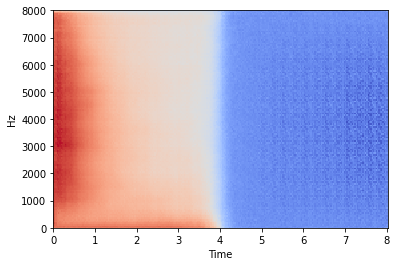

Weights saved in train_results/vae/20200810-220140/model-8866.weights
[1,  8900] loss : (total : 0.2197, recon : 0.1868, kl : 32.9407)
[1,  9000] loss : (total : 0.1900, recon : 0.1560, kl : 34.0160)
[1,  9100] loss : (total : 0.2097, recon : 0.1535, kl : 56.2379)
[1,  9200] loss : (total : 0.2081, recon : 0.1737, kl : 34.4822)
[1,  9300] loss : (total : 0.1953, recon : 0.1626, kl : 32.7350)
[1,  9400] loss : (total : 0.2001, recon : 0.1662, kl : 33.9129)
[1,  9500] loss : (total : 0.2090, recon : 0.1697, kl : 39.2407)
[1,  9600] loss : (total : 0.2272, recon : 0.1868, kl : 40.3371)
[1,  9700] loss : (total : 0.2229, recon : 0.1904, kl : 32.5681)
[1,  9800] loss : (total : 0.2286, recon : 0.1916, kl : 36.9786)
[1,  9900] loss : (total : 0.1613, recon : 0.1260, kl : 35.2259)
[1, 10000] loss : (total : 0.2057, recon : 0.1707, kl : 35.0742)
[1, 10100] loss : (total : 0.1784, recon : 0.1429, kl : 35.4549)
[1, 10200] loss : (total : 0.2081, recon : 0.1716, kl : 36.4799)
[1, 10300] loss : (t

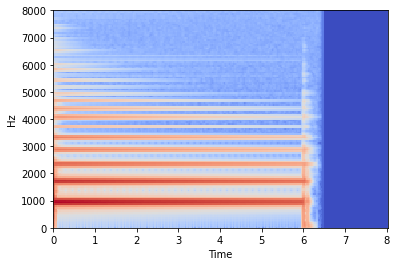

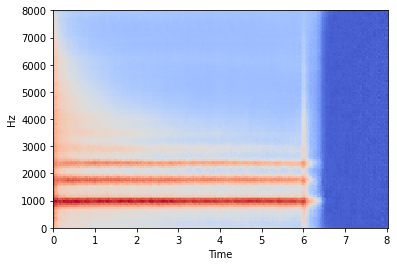

Weights saved in train_results/vae/20200810-220140/model-17732.weights
[2, 17800] loss : (total : 0.2085, recon : 0.1590, kl : 49.5262)
[2, 17900] loss : (total : 0.1726, recon : 0.1353, kl : 37.2991)
[2, 18000] loss : (total : 0.1710, recon : 0.1326, kl : 38.4642)
[2, 18100] loss : (total : 0.1576, recon : 0.1195, kl : 38.1111)
[2, 18200] loss : (total : 0.1920, recon : 0.1565, kl : 35.4809)
[2, 18300] loss : (total : 0.1716, recon : 0.1346, kl : 37.0125)
[2, 18400] loss : (total : 0.1515, recon : 0.1173, kl : 34.2283)
[2, 18500] loss : (total : 0.1753, recon : 0.1365, kl : 38.7847)
[2, 18600] loss : (total : 0.1746, recon : 0.1354, kl : 39.1763)
[2, 18700] loss : (total : 0.1632, recon : 0.1265, kl : 36.7334)
[2, 18800] loss : (total : 0.1823, recon : 0.1377, kl : 44.6060)
[2, 18900] loss : (total : 0.1772, recon : 0.1375, kl : 39.6317)
[2, 19000] loss : (total : 0.2087, recon : 0.1700, kl : 38.7340)
[2, 19100] loss : (total : 0.1810, recon : 0.1417, kl : 39.2838)
[2, 19200] loss : (

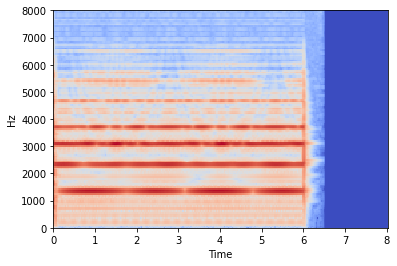

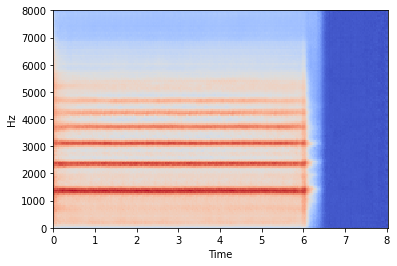

Weights saved in train_results/vae/20200810-220140/model-26598.weights
[3, 26600] loss : (total : 0.1482, recon : 0.1097, kl : 38.5783)
[3, 26700] loss : (total : 0.1638, recon : 0.1260, kl : 37.8426)
[3, 26800] loss : (total : 0.1260, recon : 0.0925, kl : 33.5425)
[3, 26900] loss : (total : 0.1423, recon : 0.1075, kl : 34.8074)
[3, 27000] loss : (total : 0.1293, recon : 0.0905, kl : 38.7390)
[3, 27100] loss : (total : 0.1379, recon : 0.1027, kl : 35.2243)
[3, 27200] loss : (total : 0.1402, recon : 0.1048, kl : 35.3903)
[3, 27300] loss : (total : 0.1820, recon : 0.1447, kl : 37.2723)
[3, 27400] loss : (total : 0.1410, recon : 0.1068, kl : 34.1208)
[3, 27500] loss : (total : 0.1509, recon : 0.1136, kl : 37.3393)
[3, 27600] loss : (total : 0.1577, recon : 0.1107, kl : 47.0104)
[3, 27700] loss : (total : 0.1734, recon : 0.1381, kl : 35.3199)
[3, 27800] loss : (total : 0.1574, recon : 0.1244, kl : 33.0614)
[3, 27900] loss : (total : 0.1547, recon : 0.1202, kl : 34.5081)
[3, 28000] loss : (

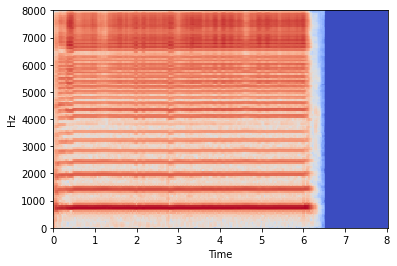

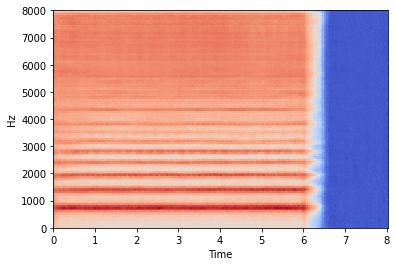

Weights saved in train_results/vae/20200810-220140/model-35464.weights
[4, 35500] loss : (total : 0.1153, recon : 0.0846, kl : 30.6926)
[4, 35600] loss : (total : 0.1261, recon : 0.0952, kl : 30.8968)
[4, 35700] loss : (total : 0.1075, recon : 0.0782, kl : 29.3177)
[4, 35800] loss : (total : 0.1217, recon : 0.0893, kl : 32.3990)
[4, 35900] loss : (total : 0.1085, recon : 0.0749, kl : 33.6362)
[4, 36000] loss : (total : 0.1244, recon : 0.0911, kl : 33.3126)
[4, 36100] loss : (total : 0.1326, recon : 0.1034, kl : 29.1654)
[4, 36200] loss : (total : 0.1146, recon : 0.0824, kl : 32.2696)
[4, 36300] loss : (total : 0.1191, recon : 0.0881, kl : 31.0144)
[4, 36400] loss : (total : 0.1253, recon : 0.0929, kl : 32.4870)
[4, 36500] loss : (total : 0.1118, recon : 0.0829, kl : 28.9085)
[4, 36600] loss : (total : 0.1192, recon : 0.0876, kl : 31.5996)
[4, 36700] loss : (total : 0.1495, recon : 0.1164, kl : 33.0863)
[4, 36800] loss : (total : 0.1279, recon : 0.0972, kl : 30.6331)
[4, 36900] loss : (

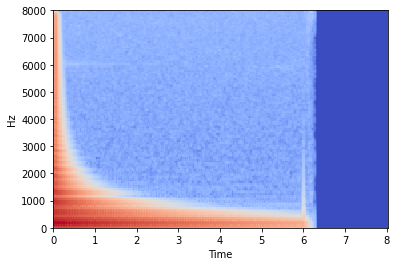

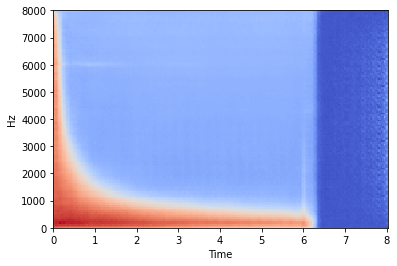

Weights saved in train_results/vae/20200810-220140/model-44330.weights
[5, 44400] loss : (total : 0.0945, recon : 0.0660, kl : 28.5391)
[5, 44500] loss : (total : 0.1091, recon : 0.0773, kl : 31.8447)
[5, 44600] loss : (total : 0.1179, recon : 0.0889, kl : 28.9939)
[5, 44700] loss : (total : 0.1107, recon : 0.0810, kl : 29.6986)
[5, 44800] loss : (total : 0.1035, recon : 0.0737, kl : 29.7716)
[5, 44900] loss : (total : 0.1086, recon : 0.0793, kl : 29.3200)
[5, 45000] loss : (total : 0.1108, recon : 0.0808, kl : 30.0150)
[5, 45100] loss : (total : 0.1147, recon : 0.0856, kl : 29.1669)
[5, 45200] loss : (total : 0.1102, recon : 0.0808, kl : 29.3944)
[5, 45300] loss : (total : 0.1035, recon : 0.0750, kl : 28.4654)
[5, 45400] loss : (total : 0.1116, recon : 0.0813, kl : 30.3063)
[5, 45500] loss : (total : 0.0998, recon : 0.0716, kl : 28.1762)
[5, 45600] loss : (total : 0.1110, recon : 0.0807, kl : 30.3248)
[5, 45700] loss : (total : 0.0969, recon : 0.0683, kl : 28.5684)
[5, 45800] loss : (

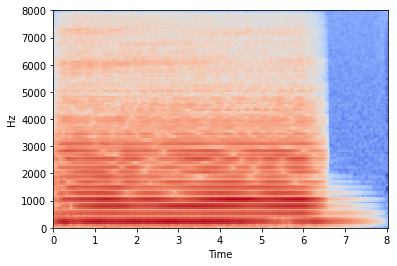

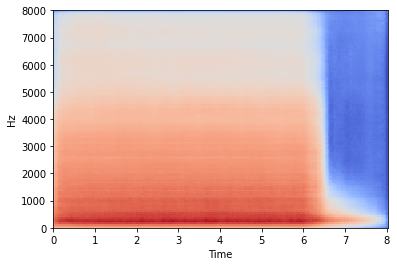

Weights saved in train_results/vae/20200810-220140/model-53196.weights
[6, 53200] loss : (total : 0.1041, recon : 0.0759, kl : 28.2122)
[6, 53300] loss : (total : 0.1017, recon : 0.0743, kl : 27.4279)
[6, 53400] loss : (total : 0.0932, recon : 0.0656, kl : 27.6515)
[6, 53500] loss : (total : 0.0928, recon : 0.0651, kl : 27.7376)
[6, 53600] loss : (total : 0.0916, recon : 0.0642, kl : 27.4636)
[6, 53700] loss : (total : 0.0966, recon : 0.0674, kl : 29.1778)
[6, 53800] loss : (total : 0.1337, recon : 0.1052, kl : 28.5354)
[6, 53900] loss : (total : 0.0939, recon : 0.0650, kl : 28.9010)
[6, 54000] loss : (total : 0.1031, recon : 0.0747, kl : 28.4758)
[6, 54100] loss : (total : 0.1089, recon : 0.0806, kl : 28.3253)
[6, 54200] loss : (total : 0.0999, recon : 0.0709, kl : 29.0884)
[6, 54300] loss : (total : 0.0955, recon : 0.0685, kl : 27.0082)
[6, 54400] loss : (total : 0.1022, recon : 0.0739, kl : 28.3683)
[6, 54500] loss : (total : 0.0978, recon : 0.0690, kl : 28.8297)
[6, 54600] loss : (

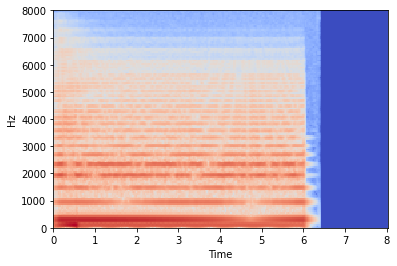

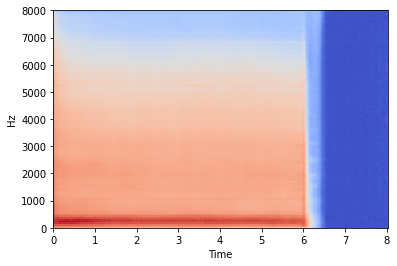

[7, 62100] loss : (total : 0.0856, recon : 0.0580, kl : 27.5892)
[7, 62200] loss : (total : 0.0825, recon : 0.0544, kl : 28.0522)
[7, 62300] loss : (total : 0.0869, recon : 0.0591, kl : 27.7436)
[7, 62400] loss : (total : 0.0961, recon : 0.0690, kl : 27.1691)
[7, 62500] loss : (total : 0.0851, recon : 0.0570, kl : 28.0669)
[7, 62600] loss : (total : 0.0947, recon : 0.0674, kl : 27.2911)
[7, 62700] loss : (total : 0.0907, recon : 0.0627, kl : 27.9564)
[7, 62800] loss : (total : 0.0855, recon : 0.0589, kl : 26.6100)
[7, 62900] loss : (total : 0.0851, recon : 0.0582, kl : 26.9437)
[7, 63000] loss : (total : 0.0770, recon : 0.0494, kl : 27.6527)
[7, 63100] loss : (total : 0.0784, recon : 0.0499, kl : 28.4127)
[7, 63200] loss : (total : 0.0980, recon : 0.0702, kl : 27.8020)
[7, 63300] loss : (total : 0.0780, recon : 0.0507, kl : 27.3044)
[7, 63400] loss : (total : 0.0900, recon : 0.0619, kl : 28.0881)
[7, 63500] loss : (total : 0.0895, recon : 0.0609, kl : 28.6218)
[7, 63600] loss : (total 

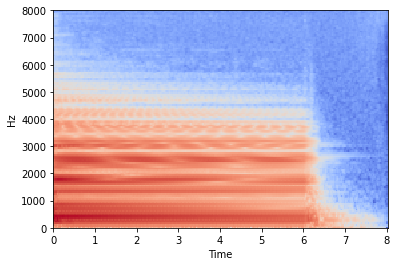

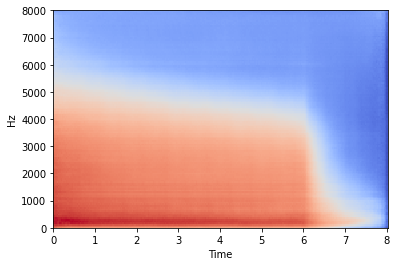

[8, 71000] loss : (total : 0.0786, recon : 0.0517, kl : 26.8862)
[8, 71100] loss : (total : 0.1098, recon : 0.0812, kl : 28.6170)
[8, 71200] loss : (total : 0.0994, recon : 0.0715, kl : 27.8827)
[8, 71300] loss : (total : 0.0850, recon : 0.0573, kl : 27.6912)
[8, 71400] loss : (total : 0.1023, recon : 0.0737, kl : 28.6256)
[8, 71500] loss : (total : 0.1042, recon : 0.0766, kl : 27.5737)
[8, 71600] loss : (total : 0.1032, recon : 0.0732, kl : 30.0059)
[8, 71700] loss : (total : 0.0857, recon : 0.0584, kl : 27.3056)
[8, 71800] loss : (total : 0.1070, recon : 0.0780, kl : 28.9499)
[8, 71900] loss : (total : 0.1040, recon : 0.0755, kl : 28.5812)
[8, 72000] loss : (total : 0.0997, recon : 0.0715, kl : 28.2226)
[8, 72100] loss : (total : 0.0942, recon : 0.0667, kl : 27.4894)
[8, 72200] loss : (total : 0.1037, recon : 0.0751, kl : 28.5790)
[8, 72300] loss : (total : 0.0800, recon : 0.0514, kl : 28.6143)
[8, 72400] loss : (total : 0.0955, recon : 0.0678, kl : 27.6789)
[8, 72500] loss : (total 

In [ ]:
if hparams['standardize']:
    recon_loss_fn = nn.MSELoss()
else:
    recon_loss_fn = nn.BCELoss()
    
kl_loss_fn = lambda mu, log_var : torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim=0)

ckpt_weights_path = None
best_loss = 1e10
since_best = 0
done = False

if hparams['checkpoint']:
    print_and_log('Resuming training from {}'.format(hparams['checkpoint']), log_file)
    ckpt = torch.load(hparams['checkpoint'])
    epoch = ckpt['epoch']
    itr = ckpt['itr']
    optimizer.load_state_dict(ckpt['optimizer'])
    model.load_state_dict(ckpt['model'])
    best_loss = ckpt['best_loss']
else:
    epoch = 0
    itr = 0

for epoch in range(epoch, hparams['n_epochs']):
    if done:
        break
    
    for batch in train_dataloader:
        if done:
            break
            
        itr += 1
        batch = batch.to(device)
        outputs, mu, log_var = model(batch)
        
        recon_loss = recon_loss_fn(outputs, batch)
        kl_loss = kl_loss_fn(mu, log_var)
        loss = recon_loss + hparams['kl_loss_weight']*kl_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (itr % hparams['display_iters'] == 0) or (itr == 1):
            print_and_log('[{}, {:5d}] loss : (total : {:.4f}, recon : {:.4f}, kl : {:.4f})'\
                          .format(epoch, itr, loss.item(), recon_loss.item(), kl_loss.item()), log_file)
            
    # validation
    model.eval()
    with torch.no_grad():
        ct, i, val_loss, val_recon_loss, val_kl_loss = 0, 0, 0.0, 0.0, 0.0
        for batch in val_dataloader:
            i += 1
            ct += batch.size(0)
            batch = batch.to(device)
            outputs, mu, log_var = model(batch, sample=False)

            recon_loss = recon_loss_fn(outputs, batch)
            kl_loss = kl_loss_fn(mu, log_var)
            loss = recon_loss + hparams['kl_loss_weight']*kl_loss
            
            val_recon_loss += (recon_loss.item() - val_recon_loss)/i
            val_kl_loss += (kl_loss.item() - val_kl_loss)/i
            val_loss += (loss.item() - val_loss)/i

            if ct >= hparams['n_val_samples']:
                break

    print_and_log('Val - loss : (total : {:.4f}, recon : {:.4f}, kl : {:.4f})'\
                  .format(val_loss, val_recon_loss, val_kl_loss), log_file)
    
    librosa.display.specshow(batch[0][0].cpu().numpy(), sr=16000, x_axis='time', y_axis='hz')
    plt.show()
    librosa.display.specshow(outputs[0][0].detach().cpu().numpy(), sr=16000, x_axis='time', y_axis='hz')
    plt.show()

    if val_loss < best_loss:
        since_best = 0
        best_loss = val_loss

        # save weights
        ckpt_weights_path = os.path.join(results_dir, 'model-{}.weights'.format(itr))
        torch.save(model.state_dict(), ckpt_weights_path)
        print_and_log('Weights saved in {}'.format(ckpt_weights_path), log_file)

        # save meta information
        ckpt_meta_path = os.path.join(results_dir, 'checkpoint')
        torch.save({
            'best_loss' : best_loss,
            'epoch' : epoch,
            'itr' : itr,
            'optimizer' : optimizer.state_dict(),
            'model' : model.state_dict()
        }, ckpt_meta_path)
    else:
        since_best += 1
        if since_best >= hparams['n_early_stopping']:
            done = True
            print_and_log('Early stopping... training complete', log_file)

    model.train()